# RDC Data Generation

This notebook generates and analyzes synthetic data for the Radial Deformation Correction (RDC) model.

**Key Functions:**
1. **Data Loading**: Reads bubble properties from CSV files.
2. **Statistical Analysis**: Computes pixel counts and dimensions (width/height).
3. **Visualization**: Plots histograms of bubble characteristics.
4. **Synthetic Data Creation**: Generates training datasets for the RDC model.

**Input**: `data/RDC/Synth_Testdata`
**Output**: `data/RDC/Synthetic_RDC`

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import hashlib
import shutil
import random
import multiprocessing
import tensorflow as tf
from utils_StarBub import HiddenReco, RDObj, Bubble

In [2]:
# Configuration
SOURCE_DIR = os.path.abspath('data/RDC/Synth_Testdata')
DEST_DIR = os.path.abspath('data/RDC/Synth_Reconstructed')
UNIQUE_DIR = os.path.abspath('data/RDC/Synth_Unique')
RDC_DIR = os.path.abspath('data/RDC/Synthetic_RDC')
MODEL_PATH = os.path.abspath('Models/RDC/RDC_PAPER')
IMG_SIZE = (256, 256)
METRIC = 5.2E-5 # Optimized Metric

## 1. Original Data Analysis & Statistics

### 1.1 Bubble Statistics  


In [3]:
def load_data(source_dir):
    print("Loading data...")
    alpha_folders = glob.glob(os.path.join(source_dir, 'alpha_*'))
    stats = []
    
    for alpha_folder in alpha_folders:
        folder_name = os.path.basename(alpha_folder)
        alpha_val = folder_name.replace('alpha_', '')
        print(f"Processing {folder_name}...")
        
        csv_files = glob.glob(os.path.join(alpha_folder, '_PointsImage*', '_Count_*.csv'))
        
        for csv_path in tqdm(csv_files):
            try:
                df = pd.read_csv(csv_path, skipinitialspace=True)
                if 'x' not in df.columns or 'y' not in df.columns:
                     df = pd.read_csv(csv_path)
                     df.columns = [c.strip() for c in df.columns]
                
                if len(df) == 0:
                    continue
                    
                # 1. Pixel Count
                pixel_count = len(df)
                
                # 2. Dimensions
                # Cast to int as requested
                x_values = df['x'].astype(int)
                y_values = df['y'].astype(int)
                
                width = x_values.max() - x_values.min() + 1
                height = y_values.max() - y_values.min() + 1
                
                stats.append({
                    'alpha': alpha_val,
                    'pixel_count': pixel_count,
                    'width': width,
                    'height': height
                })
            except Exception as e:
                print(f"Error reading {csv_path}: {e}")
                
    return pd.DataFrame(stats)

### 1.2 Statistical Visualization

In [4]:
def plot_pixel_counts(df):
    # 1. Plot All
    plt.figure(figsize=(10, 6))
    plt.hist(df['pixel_count'], bins=50, color='skyblue', edgecolor='black')
    plt.title('Distribution of Pixel Counts (All Bubbles)')
    plt.xlabel('Number of Pixels')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # 2. Plot per Alpha
    alphas = sorted(df['alpha'].unique())
    for alpha in alphas:
        subset = df[df['alpha'] == alpha]
        plt.figure(figsize=(10, 6))
        plt.hist(subset['pixel_count'], bins=30, color='lightgreen', edgecolor='black')
        plt.title(f'Distribution of Pixel Counts (Alpha = {alpha})')
        plt.xlabel('Number of Pixels')
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)
        plt.show()

In [5]:
def plot_dimensions(df):
    # 1. Plot All
    plt.figure(figsize=(10, 6))
    plt.hist(df['width'], bins=50, alpha=0.5, label='Width', color='blue', edgecolor='black')
    plt.hist(df['height'], bins=50, alpha=0.5, label='Height', color='orange', edgecolor='black')
    plt.title('Distribution of Dimensions (All Bubbles)')
    plt.xlabel('Size (pixels)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # 2. Plot per Alpha
    alphas = sorted(df['alpha'].unique())
    for alpha in alphas:
        subset = df[df['alpha'] == alpha]
        plt.figure(figsize=(10, 6))
        plt.hist(subset['width'], bins=30, alpha=0.5, label='Width', color='blue', edgecolor='black')
        plt.hist(subset['height'], bins=30, alpha=0.5, label='Height', color='orange', edgecolor='black')
        plt.title(f'Distribution of Dimensions (Alpha = {alpha})')
        plt.xlabel('Size (pixels)')
        plt.ylabel('Frequency')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

In [6]:
def print_summary(df):
    print("\n--- Statistics Summary ---")
    print(df.describe())
    
    print("\n--- Summary by Alpha (Mean) ---")
    print(df.groupby('alpha').mean())
    
    print("\n--- Width Statistics by Alpha ---")
    print(df.groupby('alpha')['width'].agg(['min', 'max', 'mean']))
    
    print("\n--- Height Statistics by Alpha ---")
    print(df.groupby('alpha')['height'].agg(['min', 'max', 'mean']))

# 2. Bubble Reconstruction (png) & Data Filtering

2.1 Draw Bubbles   
  - Each CSV file stores all pixel coordinates of a bubble on the original image background
  - Create images, each bubble placed on a 256x256 background

In [7]:
def generate_images(source_dir, dest_dir):
    print("Starting image generation...")
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)
        
    alpha_folders = glob.glob(os.path.join(source_dir, 'alpha_*'))
    
    count = 0
    for alpha_folder in alpha_folders:
        folder_name = os.path.basename(alpha_folder)
        dest_alpha_folder = os.path.join(dest_dir, folder_name)
        if not os.path.exists(dest_alpha_folder):
            os.makedirs(dest_alpha_folder)
            
        print(f"Generating images for {folder_name}...")
        
        # Find _PointsImage folders
        points_folders = glob.glob(os.path.join(alpha_folder, '_PointsImage*'))
        
        for points_folder in tqdm(points_folders):
            image_id = os.path.basename(points_folder).replace('_PointsImage', '')
            csv_files = glob.glob(os.path.join(points_folder, '_Count_*.csv'))
            
            for csv_path in csv_files:
                try:
                    bubble_id = os.path.basename(csv_path).replace('_Count_', '').replace('.csv', '')
                    output_filename = f"{image_id}_{bubble_id}.png"
                    output_path = os.path.join(dest_alpha_folder, output_filename)
                    
                    # Read CSV
                    df = pd.read_csv(csv_path, skipinitialspace=True)
                    if 'x' not in df.columns or 'y' not in df.columns:
                         df = pd.read_csv(csv_path)
                         df.columns = [c.strip() for c in df.columns]
                    
                    if len(df) == 0:
                        continue
                        
                    # Cast to int
                    x = df['x'].astype(int).values
                    y = df['y'].astype(int).values
                    
                    # Shift to (0, 0)
                    min_x = np.min(x)
                    min_y = np.min(y)
                    
                    x_shifted = x - min_x
                    y_shifted = y - min_y
                    
                    # Create image
                    img = Image.new('L', IMG_SIZE, 0)
                    pixels = img.load()
                    
                    # Set pixels
                    for i in range(len(x_shifted)):
                        px, py = x_shifted[i], y_shifted[i]
                        if 0 <= px < IMG_SIZE[0] and 0 <= py < IMG_SIZE[1]:
                            pixels[int(px), int(py)] = 255
                            
                    img.save(output_path)
                    count += 1
                    
                except Exception as e:
                    print(f"Error processing {csv_path}: {e}")
                    
    print(f"\nGeneration Complete! Generated {count} images.")

2.2 Validate generated bubbles against original CSV files based on:
 - Bubble Pixel count
 - Bubble height
 - Bubble width

In [8]:
def verify_generation(source_dir, dest_dir):
    print("Starting verification...")
    alpha_folders = glob.glob(os.path.join(dest_dir, 'alpha_*'))
    
    total_checked = 0
    errors = 0
    
    for alpha_folder in alpha_folders:
        folder_name = os.path.basename(alpha_folder)
        print(f"Verifying {folder_name}...")
        
        images = glob.glob(os.path.join(alpha_folder, '*.png'))
        
        for img_path in tqdm(images):
            try:
                filename = os.path.basename(img_path)
                image_id, bubble_id = filename.replace('.png', '').split('_')
                
                # 1. Analyze Image
                img = Image.open(img_path)
                img_arr = np.array(img)
                
                # Pixel Count
                pixel_count_img = np.count_nonzero(img_arr)
                
                # Dimensions from Image
                rows, cols = np.nonzero(img_arr)
                if len(rows) == 0:
                    width_img = 0
                    height_img = 0
                else:
                    # Note: rows are y, cols are x
                    min_y, max_y = np.min(rows), np.max(rows)
                    min_x, max_x = np.min(cols), np.max(cols)
                    width_img = max_x - min_x + 1
                    height_img = max_y - min_y + 1
                
                # 2. Analyze CSV
                csv_path = os.path.join(source_dir, folder_name, f'_PointsImage{image_id}', f'_Count_{bubble_id}.csv')
                if not os.path.exists(csv_path):
                    print(f"CSV missing for {filename}")
                    continue
                    
                df = pd.read_csv(csv_path, skipinitialspace=True)
                if 'x' not in df.columns or 'y' not in df.columns:
                     df = pd.read_csv(csv_path)
                     df.columns = [c.strip() for c in df.columns]
                
                # Pixel Count (Rows)
                pixel_count_csv = len(df)
                
                # Dimensions from CSV (int cast)
                x = df['x'].astype(int)
                y = df['y'].astype(int)
                width_csv = x.max() - x.min() + 1
                height_csv = y.max() - y.min() + 1
                
                # 3. Compare
                if pixel_count_img != pixel_count_csv:
                    print(f"Mismatch Pixel Count {filename}: Img={pixel_count_img}, CSV={pixel_count_csv}")
                    errors += 1
                elif width_img != width_csv:
                    print(f"Mismatch Width {filename}: Img={width_img}, CSV={width_csv}")
                    errors += 1
                elif height_img != height_csv:
                    print(f"Mismatch Height {filename}: Img={height_img}, CSV={height_csv}")
                    errors += 1
                    
                total_checked += 1
                
            except Exception as e:
                print(f"Error verifying {filename}: {e}")
                
    print(f"\nVerification Complete!")
    print(f"Total Checked: {total_checked}")
    print(f"Errors Found: {errors}")

2.3 Identify duplicate bubbles

In [9]:
def check_duplicates(dest_dir):
    print("Checking for duplicates...")
    alpha_folders = glob.glob(os.path.join(dest_dir, 'alpha_*'))
    
    # Dictionary to store hash -> list of filenames
    hashes = {}
    
    for alpha_folder in alpha_folders:
        folder_name = os.path.basename(alpha_folder)
        print(f"Scanning {folder_name}...")
        
        images = glob.glob(os.path.join(alpha_folder, '*.png'))
        
        for img_path in tqdm(images):
            try:
                with open(img_path, 'rb') as f:
                    file_hash = hashlib.md5(f.read()).hexdigest()
                    
                if file_hash in hashes:
                    hashes[file_hash].append(img_path)
                else:
                    hashes[file_hash] = [img_path]
            except Exception as e:
                print(f"Error hashing {img_path}: {e}")
                
    # Find duplicates
    duplicates = {k: v for k, v in hashes.items() if len(v) > 1}
    
    print(f"\nFound {len(duplicates)} groups of duplicates.")
    
    if len(duplicates) > 0:
        print("\nDuplicate Groups:")
        for h, paths in duplicates.items():
            print(f"Hash: {h}")
            for p in paths:
                print(f"  - {p}")
            print("-" * 20)

2.4 Remove duplicate bubbles

In [10]:
def filter_unique_bubbles(dest_dir, unique_dir):
    print("Filtering unique bubbles...")
    if not os.path.exists(unique_dir):
        os.makedirs(unique_dir)
    else:
        # Clean up existing
        shutil.rmtree(unique_dir)
        os.makedirs(unique_dir)
        
    alpha_folders = glob.glob(os.path.join(dest_dir, 'alpha_*'))
    
    seen_hashes = set()
    count = 0
    
    for alpha_folder in alpha_folders:
        folder_name = os.path.basename(alpha_folder)
        print(f"Scanning {folder_name}...")
        
        images = glob.glob(os.path.join(alpha_folder, '*.png'))
        
        for img_path in tqdm(images):
            try:
                with open(img_path, 'rb') as f:
                    file_hash = hashlib.md5(f.read()).hexdigest()
                    
                if file_hash not in seen_hashes:
                    seen_hashes.add(file_hash)
                    
                    # Copy to unique folder
                    new_filename = f"bubble_{count}.png"
                    new_path = os.path.join(unique_dir, new_filename)
                    shutil.copy(img_path, new_path)
                    count += 1
                    
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
                
    print(f"\nFiltering Complete!")
    print(f"Total Unique Bubbles: {count}")

# 3. Generate Synthetic RDC Data (Synthetic RDC Data)

### 3.1 Generate Overlapping Images
  - Randomly select 2-3 images (representing 2-3 bubbles)
  - Place bubbles overlapping each other at random positions
  - Create overlapping mask

In [11]:
def generate_rdc_data(unique_dir, rdc_dir, num_samples=60000):
    print("Generating RDC data...")
    mask_dir = os.path.join(rdc_dir, 'Masks')
    if not os.path.exists(mask_dir):
        os.makedirs(mask_dir)
        
    # Load bubbles
    bubble_paths = glob.glob(os.path.join(unique_dir, '*.png'))
    bubbles = []
    bubble_names = []
    for p in tqdm(bubble_paths, desc="Loading bubbles"):
        try:
            img = Image.open(p)
            arr = np.array(img) > 128
            bubbles.append(arr)
            bubble_names.append(os.path.basename(p))
        except Exception as e:
            print(f"Error loading {p}: {e}")
            
    print(f"Loaded {len(bubbles)} unique bubbles.")
    
    # Helper functions
    def get_crop_size(bubble_arr):
        rows, cols = np.nonzero(bubble_arr)
        if len(rows) == 0: return 0, 0
        return rows.max() - rows.min() + 1, cols.max() - cols.min() + 1

    def place_bubble(bubble_arr, r, c):
        rows, cols = np.nonzero(bubble_arr)
        if len(rows) == 0: return None
        min_r, max_r = rows.min(), rows.max()
        min_c, max_c = cols.min(), cols.max()
        
        crop = bubble_arr[min_r:max_r+1, min_c:max_c+1]
        crop_h, crop_w = crop.shape
        
        canvas = np.zeros(IMG_SIZE, dtype=bool)
        
        # Handle out of bounds coordinates
        start_r = max(0, r)
        end_r = min(IMG_SIZE[0], r + crop_h)
        start_c = max(0, c)
        end_c = min(IMG_SIZE[1], c + crop_w)
        
        # Calculate source crop coordinates
        crop_start_r = start_r - r
        crop_end_r = crop_start_r + (end_r - start_r)
        crop_start_c = start_c - c
        crop_end_c = crop_start_c + (end_c - start_c)
        
        if end_r > start_r and end_c > start_c:
            canvas[start_r:end_r, start_c:end_c] = crop[crop_start_r:crop_end_r, crop_start_c:crop_end_c]
            return canvas
        return None

    # Generation Loop
    for sample_id in tqdm(range(num_samples), desc="Generating samples"):
        # Randomly choose 2 or 3 bubbles
        num_bubbles = random.choice([2, 3])
        selected_indices = random.sample(range(len(bubbles)), num_bubbles)
        selected_bubbles = [bubbles[i] for i in selected_indices]
        selected_names = [bubble_names[i] for i in selected_indices]
        
        composition = np.zeros(IMG_SIZE, dtype=bool)
        instance_mask = np.zeros(IMG_SIZE, dtype=np.uint8)
        placed_bubbles = [] # (mask, area)
        placed_positions = [] # (r, c)
        
        # Place first bubble
        b1 = selected_bubbles[0]
        bh1, bw1 = get_crop_size(b1)
        
        # Allow partial edge clipping (e.g., -20% to ImageSize - 80%)
        # This ensures at least ~80% of the bubble is initially "aiming" for the canvas, 
        # but allows edges to be cut.
        margin_h = int(bh1 * 0.2)
        margin_w = int(bw1 * 0.2)
        
        r1 = random.randint(-margin_h, max(0, IMG_SIZE[0] - bh1 + margin_h))
        c1 = random.randint(-margin_w, max(0, IMG_SIZE[1] - bw1 + margin_w))
        
        placed_b1 = place_bubble(b1, r1, c1)
        # If placement failed entirely (off screen) or too small area visible?
        # place_bubble returns None only if crop failed, which shouldn't happen with this logic 
        # unless completely off, but we clamped logic.
        
        if placed_b1 is None or np.count_nonzero(placed_b1) == 0: 
            # Fallback to safe placement if it failed
            r1 = random.randint(0, max(0, IMG_SIZE[0] - bh1))
            c1 = random.randint(0, max(0, IMG_SIZE[1] - bw1))
            placed_b1 = place_bubble(b1, r1, c1)
            
        if placed_b1 is None: continue

        composition = np.logical_or(composition, placed_b1)
        instance_mask[placed_b1] = 1
        placed_bubbles.append((placed_b1, np.count_nonzero(placed_b1)))
        placed_positions.append((r1, c1))
        
        # Place others
        valid_sample = True
        for i in range(1, num_bubbles):
            b_next = selected_bubbles[i]
            bh, bw = get_crop_size(b_next)
            b_area = np.count_nonzero(b_next)
            
            placed = False
            retries = 0
            max_retries = 100
            
            while not placed and retries < max_retries:
                margin_h = int(bh * 0.2)
                margin_w = int(bw * 0.2)
                r = random.randint(-margin_h, max(0, IMG_SIZE[0] - bh + margin_h))
                c = random.randint(-margin_w, max(0, IMG_SIZE[1] - bw + margin_w))
                
                candidate = place_bubble(b_next, r, c)
                if candidate is None or np.count_nonzero(candidate) == 0:
                    retries += 1
                    continue
                
                # Check constraints
                valid_placement = True
                for prev_mask, prev_area in placed_bubbles:
                    intersection = np.logical_and(candidate, prev_mask)
                    inter_area = np.count_nonzero(intersection)
                    if inter_area > 0:
                        # Logic: New bubble shouldn't hide too much of Old
                        if inter_area / prev_area > 0.9: 
                            valid_placement = False; break
                        # Logic: Old bubble shouldn't hide too much of New
                        # Note: candidate might be smaller than b_next due to border crop.
                        candidate_area = np.count_nonzero(candidate)
                        if inter_area / candidate_area > 0.9: 
                            valid_placement = False; break
                
                if not valid_placement:
                    retries += 1
                    continue
                    
                # Overlap constraint with total composition
                total_intersection = np.logical_and(candidate, composition)
                total_inter_area = np.count_nonzero(total_intersection)
                
                candidate_area = np.count_nonzero(candidate)
                # Ensure the new bubble isn't almost entirely hidden
                if total_inter_area / candidate_area > 0.9: # 90% hidden is too much
                     retries += 1
                     continue

                # Ensure we have *some* meaningful area (not just 1 pixel on edge)
                if candidate_area < b_area * 0.2: # If cropping reduced it to < 20% of original
                     retries += 1 
                     continue
                    
                composition = np.logical_or(composition, candidate)
                instance_mask[candidate] = i + 1
                placed_bubbles.append((candidate, candidate_area))
                placed_positions.append((r, c))
                placed = True
            
            if not placed:
                valid_sample = False
                break
        
        if valid_sample:
            # Save Mask
            mask_filename = f"rdc_{sample_id}.png"
            mask_path = os.path.join(mask_dir, mask_filename)
            Image.fromarray(instance_mask).save(mask_path)
            
            # Save CSV
            csv_filename = f"rdc_{sample_id}.csv"
            csv_path = os.path.join(mask_dir, csv_filename)
            
            with open(csv_path, 'w') as f:
                f.write("pixel_value,source_bubble,r,c\n")
                f.write("0,background,0,0\n")
                for i in range(num_bubbles):
                    f.write(f"{i+1},{selected_names[i]},{placed_positions[i][0]},{placed_positions[i][1]}\n")
                    
    print("RDC Generation Complete!")

3.2 Validate generated images based on conditions: (must see over 10% of bubble area)

In [12]:
def verify_geometry(rdc_dir, unique_dir, num_samples_to_check=1000):
    print(f"Verifying geometric constraints on {num_samples_to_check} random samples...")
    
    mask_dir = os.path.join(rdc_dir, 'Masks')
    csv_files = glob.glob(os.path.join(mask_dir, '*.csv'))
    
    if len(csv_files) == 0:
        print("No data found.")
        return

    selected_files = random.sample(csv_files, min(len(csv_files), num_samples_to_check))
    
    violations = 0
    total_bubbles = 0
    violation_list = []
    
    # Cache for unique bubble areas to speed up
    bubble_area_cache = {}
    
    for csv_path in tqdm(selected_files):
        try:
            # Load CSV
            df = pd.read_csv(csv_path)
            
            # Load corresponding Mask
            mask_filename = os.path.basename(csv_path).replace('.csv', '.png')
            mask_path = os.path.join(mask_dir, mask_filename)
            
            if not os.path.exists(mask_path):
                print(f"Mask missing for {csv_path}")
                continue
                
            mask = Image.open(mask_path)
            mask_arr = np.array(mask)
            
            # Check each bubble in the sample
            # Skip background (value 0)
            bubbles_df = df[df['pixel_value'] != 0]
            
            for _, row in bubbles_df.iterrows():
                pixel_val = row['pixel_value']
                source_name = row['source_bubble']
                
                # 1. Get Original Area
                if source_name in bubble_area_cache:
                    original_area = bubble_area_cache[source_name]
                else:
                    source_path = os.path.join(unique_dir, source_name)
                    if not os.path.exists(source_path):
                        print(f"Source bubble missing: {source_name}")
                        continue
                    src_img = Image.open(source_path)
                    src_arr = np.array(src_img) > 128
                    original_area = np.count_nonzero(src_arr)
                    bubble_area_cache[source_name] = original_area
                
                # 2. Get Visible Area from Mask
                visible_area = np.count_nonzero(mask_arr == pixel_val)
                
                total_bubbles += 1
                
                # 3. Check Ratio
                ratio = visible_area / original_area
                
                if ratio < 0.1:
                    msg = f"Violation in {mask_filename} (ID {pixel_val}): Visible Ratio {ratio:.2f} < 0.1"
                    # print(msg)
                    violations += 1
                    violation_list.append(msg)
                    
        except Exception as e:
            print(f"Error processing {csv_path}: {e}")
            
    print(f"\nVerification Complete.")
    print(f"Total Bubbles Checked: {total_bubbles}")
    print(f"Violations Found (Visible < 10%): {violations}")
    print(f"Violation Rate: {violations/total_bubbles*100:.2f}%")
    
    if violations > 0:
        print("\n--- Violation List ---")
        for v in violation_list:
            print(v)

# 4. Search for METRIC (m/pixel) of current dataset

In [13]:
# --- Modularized Evaluation Functions ---

def load_rdc_model(model_path):
    try:
        model = tf.keras.models.load_model(model_path)
        print("Model loaded successfully.")
        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

def get_gt_properties(source_path, metric):
    if not os.path.exists(source_path):
        return None
        
    src_img = Image.open(source_path)
    src_arr = np.array(src_img) > 128
    
    # Create GT RDObj
    gt_mask = np.zeros_like(src_arr, dtype=int)
    gt_mask[src_arr] = 1
    
    gt_rdc = RDObj(1, 64)
    gt_rdc.generateRD_manual(gt_mask)
    
    gt_bubble_obj = Bubble(gt_rdc.points, metric, ID=1)
    
    if gt_bubble_obj.Diameter is None:
        return None
        
    area = np.pi * (gt_bubble_obj.Major/2) * (gt_bubble_obj.Minor/2)
    return area

def evaluate_sample(csv_path, mask_dir, unique_dir, model, metric):
    try:
        df = pd.read_csv(csv_path)
        mask_filename = os.path.basename(csv_path).replace('.csv', '.png')
        mask_path = os.path.join(mask_dir, mask_filename)
        
        if not os.path.exists(mask_path):
            return []
            
        labels = np.array(Image.open(mask_path))
        predicted_bubbles = HiddenReco(labels, metric, useRDC=True, model=model, boolPlot=False)
        
        sample_accs = []
        
        for pred_bubble in predicted_bubbles:
            bubble_id = pred_bubble.ID
            matches = df[df['pixel_value'] == bubble_id]
            if len(matches) == 0: continue
                
            source_name = matches.iloc[0]['source_bubble']
            source_path = os.path.join(unique_dir, source_name)
            
            gt_area = get_gt_properties(source_path, metric)
            if gt_area is None: continue
            
            pred_area = np.pi * (pred_bubble.Major/2) * (pred_bubble.Minor/2)
            
            if max(pred_area, gt_area) == 0:
                acc = 0
            else:
                acc = min(pred_area, gt_area) / max(pred_area, gt_area)
                
            if not np.isnan(acc):
                sample_accs.append(acc)
                
        return sample_accs
        
    except Exception as e:
        print(f"Error processing {csv_path}: {e}")
        return []

def evaluate_rdc_dataset(rdc_dir, unique_dir, model_path, metric, num_samples=100):
    print(f"Evaluating RDC model on {num_samples} samples with Metric={metric}...")
    
    model = load_rdc_model(model_path)
    if model is None: return
        
    mask_dir = os.path.join(rdc_dir, 'Masks')
    csv_files = glob.glob(os.path.join(mask_dir, '*.csv'))
    
    if len(csv_files) == 0:
        print("No data found.")
        return

    selected_files = random.sample(csv_files, min(len(csv_files), num_samples))
    
    all_accuracies = []
    
    for csv_path in tqdm(selected_files):
        sample_accs = evaluate_sample(csv_path, mask_dir, unique_dir, model, metric)
        if sample_accs:
            all_accuracies.append(np.mean(sample_accs))
            
    print(f"\nEvaluation Complete.")
    if len(all_accuracies) > 0:
        print(f"Mean Area Accuracy (RDObj-based): {np.nanmean(all_accuracies):.4f}")
    else:
        print("No valid accuracies computed.")

4.1 Determine optimal metric for the current dataset

In [14]:
def optimize_metric(rdc_dir, unique_dir, model_path):
    print("Starting Metric Optimization...")
    
    # 1. Load Model
    model = load_rdc_model(model_path)
    if model is None: return
    
    # 2. Select Fixed Samples
    mask_dir = os.path.join(rdc_dir, 'Masks')
    csv_files = glob.glob(os.path.join(mask_dir, '*.csv'))
    
    if len(csv_files) == 0:
        print("No data found.")
        return

    # Fix seed for reproducibility
    random.seed(42)
    selected_files = random.sample(csv_files, min(len(csv_files), 2000))
    print(f"Selected {len(selected_files)} fixed samples.")
    
    # 3. Define Metric Range
    # 1.0E-5 to 9.9E-5, step 0.1E-5
    metrics = np.arange(4.0, 7.0, 0.1) * 1e-5
    results = []
    
    print(f"Testing {len(metrics)} metric values...")
    
    for metric in tqdm(metrics):
        all_accuracies = []
        for csv_path in selected_files:
            sample_accs = evaluate_sample(csv_path, mask_dir, unique_dir, model, metric)
            if sample_accs:
                all_accuracies.append(np.mean(sample_accs))
        
        if all_accuracies:
            mean_acc = np.nanmean(all_accuracies)
            results.append((metric, mean_acc))
        else:
            results.append((metric, 0))
            
    # 4. Plot Results
    metrics_val = [r[0] for r in results]
    accuracies_val = [r[1] for r in results]
    
    best_idx = np.argmax(accuracies_val)
    best_metric = metrics_val[best_idx]
    best_acc = accuracies_val[best_idx]
    
    print(f"\nOptimization Complete.")
    print(f"Best Metric: {best_metric:.2e}")
    print(f"Best Accuracy: {best_acc:.4f}")
    
    plt.figure(figsize=(12, 6))
    plt.plot(metrics_val, accuracies_val, marker='o', linestyle='-', markersize=4)
    plt.axvline(x=best_metric, color='r', linestyle='--', label=f'Best: {best_metric:.2e}')
    plt.title('Mean Area Accuracy vs. Metric')
    plt.xlabel('Metric (m/pixel)')
    plt.ylabel('Mean Area Accuracy')
    plt.grid(True)
    plt.legend()
    plt.show()

# 5. Create Dataset for RDC Model
  - Input, Output: Vector, each containing 64 values corresponding to the distance from center pixel to bubble edge, in meters
  - Input generation: From synthetic image, determine 64 values for each bubble
  - Input generation: From synthetic image, referencing the unmerged image (complete bubble), determine 64 rays based on this image

In [15]:
def generate_training_data(rdc_dir, unique_dir, metric=5.2E-2):
    print("Generating RDC Training Data (Array-64)...")
    
    mask_dir = os.path.join(rdc_dir, 'Masks')
    output_dir = os.path.join(rdc_dir, 'Array-64-'+ str(metric))
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    csv_files = glob.glob(os.path.join(mask_dir, '*.csv'))
    
    X_data = []
    Y_data = []
    
    print(f"Processing {len(csv_files)} samples...")
    
    def get_bubble_crop(bubble_arr):
        rows, cols = np.nonzero(bubble_arr)
        if len(rows) == 0: return None
        min_r, max_r = rows.min(), rows.max()
        min_c, max_c = cols.min(), cols.max()
        crop = bubble_arr[min_r:max_r+1, min_c:max_c+1]
        return crop

    skipped_count = 0
    
    for csv_path in tqdm(csv_files):
        try:
            # Load Data
            df = pd.read_csv(csv_path)
            mask_filename = os.path.basename(csv_path).replace('.csv', '.png')
            mask_path = os.path.join(mask_dir, mask_filename)
            
            if not os.path.exists(mask_path):
                continue
                
            labels = np.array(Image.open(mask_path))
            
            # Process each bubble in the mask
            for bubble_id in range(1, np.max(labels) + 1):
                # 1. Check Metadata
                matches = df[df['pixel_value'] == bubble_id]
                if len(matches) == 0:
                    continue
                    
                row = matches.iloc[0]
                source_name = row['source_bubble']
                
                if 'r' not in row or 'c' not in row:
                    continue
                
                # 2. Check Constraint: Visible Ratio >= 0.1
                source_path = os.path.join(unique_dir, source_name)
                if not os.path.exists(source_path):
                    continue
                    
                src_img = Image.open(source_path)
                src_arr = np.array(src_img) > 128
                
                visible_area = np.count_nonzero(labels == bubble_id)
                original_area = np.count_nonzero(src_arr)
                
                if original_area == 0: continue
                
                if visible_area / original_area < 0.1:
                    skipped_count += 1
                    continue
                
                # 3. Generate Input (X)
                rdc_input = RDObj(bubble_id, 64)
                rdc_input.generateRD_manual(labels)
                
                if rdc_input.center is None:
                    continue
                    
                x_dists = rdc_input.transformRDToArray(metric)
                
                # 4. Generate Target (Y) using Full GT
                r_pos = int(row['r'])
                c_pos = int(row['c'])
                
                full_crop = get_bubble_crop(src_arr)
                if full_crop is None: continue
                
                pad = 10
                padded_crop = np.pad(full_crop.astype(int), pad, mode='constant', constant_values=0)
                
                input_center_global = rdc_input.center
                local_y = input_center_global[0] - r_pos + pad
                local_x = input_center_global[1] - c_pos + pad
                local_center = (local_y, local_x)
                
                rdc_target = RDObj(1, 64, center=local_center)
                rdc_target.generateRD_manual(padded_crop)
                
                if rdc_target.center is None:
                    continue
                    
                y_dists = rdc_target.transformRDToArray(metric)
                
                X_data.append(x_dists)
                Y_data.append(y_dists)
                
        except Exception as e:
            print(f"Error processing {csv_path}: {e}")
            
    X_arr = np.array(X_data)
    Y_arr = np.array(Y_data)
    
    np.save(os.path.join(output_dir, 'X_train.npy'), X_arr)
    np.save(os.path.join(output_dir, 'Y_train.npy'), Y_arr)
    
    print(f"\\nData Generation Complete. Skipped {skipped_count} invalid bubbles (Ratio < 0.1).")

In [16]:
# 1. Statistics
df_stats = load_data(SOURCE_DIR)
#plot_pixel_counts(df_stats)
#plot_dimensions(df_stats)
print_summary(df_stats)

Loading data...
Processing alpha_0.025...


100%|██████████| 1470/1470 [00:06<00:00, 237.02it/s]


Processing alpha_0.05...


100%|██████████| 2728/2728 [00:15<00:00, 170.63it/s]


Processing alpha_0.075...


100%|██████████| 4140/4140 [00:13<00:00, 305.37it/s]


Processing alpha_0.1...


100%|██████████| 5569/5569 [00:12<00:00, 435.10it/s]


--- Statistics Summary ---
        pixel_count         width        height
count  13907.000000  13907.000000  13907.000000
mean    3534.150859     90.940318     51.285324
std     2073.861710     31.052375     16.783162
min      711.000000     36.000000     19.000000
25%     1980.500000     69.000000     39.000000
50%     2593.000000     80.000000     47.000000
75%     5290.500000    117.000000     63.000000
max     9914.000000    196.000000    121.000000

--- Summary by Alpha (Mean) ---
       pixel_count      width     height
alpha                                   
0.025  3464.174830  89.781633  50.755102
0.05   3577.781158  91.493402  51.473607
0.075  3543.331884  91.227295  51.251449
0.1    3524.424134  90.761896  51.358233

--- Width Statistics by Alpha ---
       min  max       mean
alpha                     
0.025   36  196  89.781633
0.05    36  194  91.493402
0.075   36  195  91.227295
0.1     36  194  90.761896

--- Height Statistics by Alpha ---
       min  max       mean
a

In [17]:
# 2. Generation
generate_images(SOURCE_DIR, DEST_DIR)

Starting image generation...
Generating images for alpha_0.025...


100%|██████████| 50/50 [00:08<00:00,  5.60it/s]


Generating images for alpha_0.05...


100%|██████████| 50/50 [00:15<00:00,  3.33it/s]


Generating images for alpha_0.075...


100%|██████████| 50/50 [00:21<00:00,  2.37it/s]


Generating images for alpha_0.1...


100%|██████████| 50/50 [00:27<00:00,  1.80it/s]


Generation Complete! Generated 13907 images.


In [18]:
# 3. Verification
verify_generation(SOURCE_DIR, DEST_DIR)

Starting verification...
Verifying alpha_0.025...


100%|██████████| 1470/1470 [00:19<00:00, 75.74it/s]


Verifying alpha_0.05...


100%|██████████| 2728/2728 [00:36<00:00, 74.53it/s]


Verifying alpha_0.075...


100%|██████████| 4140/4140 [00:53<00:00, 77.77it/s]


Verifying alpha_0.1...


100%|██████████| 5569/5569 [01:08<00:00, 80.98it/s]


Verification Complete!
Total Checked: 13907
Errors Found: 0


In [19]:
# 4. Duplicate Detection
check_duplicates(DEST_DIR)

Checking for duplicates...
Scanning alpha_0.025...


100%|██████████| 1470/1470 [00:00<00:00, 25194.41it/s]


Scanning alpha_0.05...


100%|██████████| 2728/2728 [00:00<00:00, 26360.25it/s]


Scanning alpha_0.075...


100%|██████████| 4140/4140 [00:00<00:00, 24168.64it/s]


Scanning alpha_0.1...


100%|██████████| 5569/5569 [00:00<00:00, 27863.20it/s]


Found 3485 groups of duplicates.

Duplicate Groups:
Hash: 02fc943844c39edc18ff966dfaef6fd3
  - e:\PTIT\Doan\Detection of Overlapping Bubbles in Industrial Imagery\data\RDC\Synth_Reconstructed\alpha_0.025\0_0.png
  - e:\PTIT\Doan\Detection of Overlapping Bubbles in Industrial Imagery\data\RDC\Synth_Reconstructed\alpha_0.075\9_13.png
  - e:\PTIT\Doan\Detection of Overlapping Bubbles in Industrial Imagery\data\RDC\Synth_Reconstructed\alpha_0.1\11_59.png
--------------------
Hash: 2007669230c610f3bf97c20db63673db
  - e:\PTIT\Doan\Detection of Overlapping Bubbles in Industrial Imagery\data\RDC\Synth_Reconstructed\alpha_0.025\0_1.png
  - e:\PTIT\Doan\Detection of Overlapping Bubbles in Industrial Imagery\data\RDC\Synth_Reconstructed\alpha_0.05\12_26.png
--------------------
Hash: 3a0c4a8391f98cb921e26f0071d4d26a
  - e:\PTIT\Doan\Detection of Overlapping Bubbles in Industrial Imagery\data\RDC\Synth_Reconstructed\alpha_0.025\0_10.png
  - e:\PTIT\Doan\Detection of Overlapping Bubbles in Indust

In [20]:
# 5. Filter Unique
filter_unique_bubbles(DEST_DIR, UNIQUE_DIR)

Filtering unique bubbles...
Scanning alpha_0.025...


100%|██████████| 1470/1470 [00:00<00:00, 2619.75it/s]


Scanning alpha_0.05...


100%|██████████| 2728/2728 [00:00<00:00, 2803.67it/s]


Scanning alpha_0.075...


100%|██████████| 4140/4140 [00:01<00:00, 3574.41it/s]


Scanning alpha_0.1...


100%|██████████| 5569/5569 [00:01<00:00, 4713.29it/s]


Filtering Complete!
Total Unique Bubbles: 9263


In [21]:
# 6. RDC Generation
generate_rdc_data(UNIQUE_DIR, RDC_DIR, num_samples=60000)

Generating RDC data...


Loading bubbles: 100%|██████████| 9263/9263 [01:31<00:00, 101.49it/s]


Loaded 9263 unique bubbles.


Generating samples: 100%|██████████| 60000/60000 [02:18<00:00, 433.54it/s]


RDC Generation Complete!


In [22]:
# 7. Geometric Verification
verify_geometry(RDC_DIR, UNIQUE_DIR, num_samples_to_check=1000)

Verifying geometric constraints on 1000 random samples...


100%|██████████| 1000/1000 [00:29<00:00, 33.82it/s]


Verification Complete.
Total Bubbles Checked: 2535
Violations Found (Visible < 10%): 2
Violation Rate: 0.08%

--- Violation List ---
Violation in rdc_45121.png (ID 1): Visible Ratio 0.05 < 0.1
Violation in rdc_56463.png (ID 1): Visible Ratio 0.07 < 0.1


In [23]:
# 8. Model Evaluation (Modular)
evaluate_rdc_dataset(RDC_DIR, UNIQUE_DIR, MODEL_PATH, METRIC, num_samples=100)

Evaluating RDC model on 100 samples with Metric=5.2e-05...
Model loaded successfully.


100%|██████████| 100/100 [00:09<00:00, 10.78it/s]


Evaluation Complete.
Mean Area Accuracy (RDObj-based): 0.9320


Starting Metric Optimization...
Model loaded successfully.
Selected 2000 fixed samples.
Testing 30 metric values...


100%|██████████| 30/30 [1:22:44<00:00, 165.48s/it]


Optimization Complete.
Best Metric: 5.20e-05
Best Accuracy: 0.9284


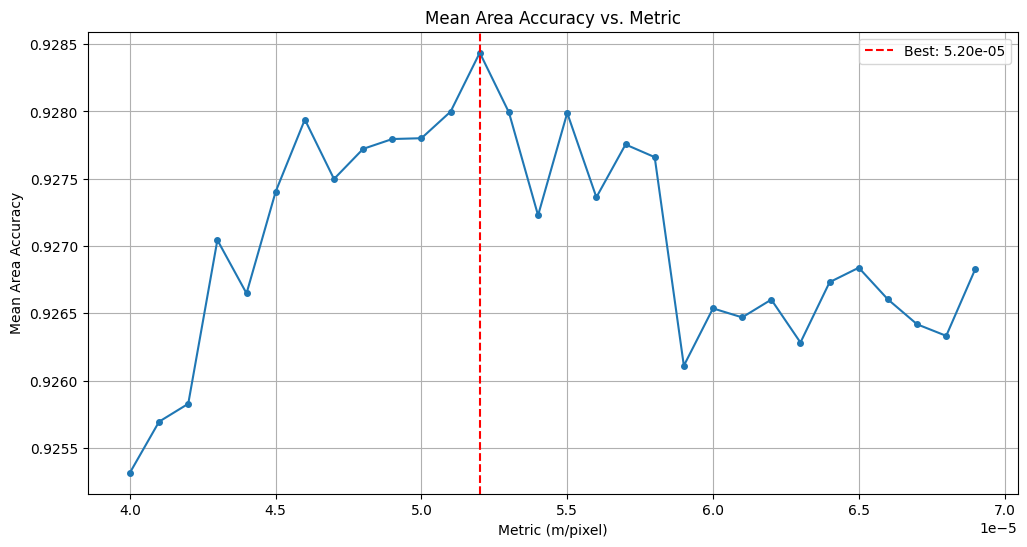

In [24]:
# 9. Metric Optimization
optimize_metric(RDC_DIR, UNIQUE_DIR, MODEL_PATH)

In [25]:
# 10. Generate Training Data
generate_training_data(RDC_DIR, UNIQUE_DIR, metric=5.2E-2)

Generating RDC Training Data (Array-64)...
Processing 60000 samples...


100%|██████████| 60000/60000 [42:58<00:00, 23.27it/s]


\nData Generation Complete. Skipped 41 invalid bubbles (Ratio < 0.1).


In [26]:
# 11. Remove Synth_Reconstructed folder after generating training data
import shutil

if os.path.exists(DEST_DIR):
    try:
        shutil.rmtree(DEST_DIR)
        print(f"Removed temporary folder: {DEST_DIR}")
    except Exception as e:
        print(f"Error removing folder: {e}")
else:
    print(f"Folder {DEST_DIR} does not exist or was already removed.")

Removed temporary folder: e:\PTIT\Doan\Detection of Overlapping Bubbles in Industrial Imagery\data\RDC\Synth_Reconstructed
